In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

from networks import ConvUpscaleDenoiser, ConvTransposeDenoiser
from utils import RunBuilder

In [2]:
# set available device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# extract and transform the data
train_set = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1)

In [4]:
runs = OrderedDict(
    networks = [ConvUpscaleDenoiser(), ConvTransposeDenoiser()]
)

In [5]:
noise_factor = 0.5  # for adding noise to the images
num_epochs = 32

for run in RunBuilder.get_runs(runs):
    model = run.networks.to(device)
    name = type(model).__name__
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):

        train_loss = 0
        ###################
        # train the model #
        ###################
        loop = tqdm(train_loader)
        for batch in loop:
            images, _ = batch
            # add random noise to the input images
            noisy_imgs = images + noise_factor * torch.randn(*images.shape)
            # clip the pixels to be between 0 and 1
            noisy_imgs = np.clip(noisy_imgs, 0, 1)
            noisy_imgs = noisy_imgs.to(device)
            images = images.to(device)
            
            outputs = model(noisy_imgs)
            loss = criterion(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            loop.set_description(f'{name:22s}| Epoch [{epoch+1:2d}/{num_epochs}]')
            loop.set_postfix(loss=train_loss)
            

    torch.save(model.state_dict(), f'models/{name}Net.pth')

ConvUpscaleDenoiser   | Epoch [ 1/32]: 100%|██████████| 235/235 [00:14<00:00, 16.20it/s, loss=3.52e+3]
ConvUpscaleDenoiser   | Epoch [ 2/32]: 100%|██████████| 235/235 [00:14<00:00, 16.10it/s, loss=1.11e+3]
ConvUpscaleDenoiser   | Epoch [ 3/32]: 100%|██████████| 235/235 [00:14<00:00, 16.19it/s, loss=879]
ConvUpscaleDenoiser   | Epoch [ 4/32]: 100%|██████████| 235/235 [00:14<00:00, 16.17it/s, loss=790]
ConvUpscaleDenoiser   | Epoch [ 5/32]: 100%|██████████| 235/235 [00:14<00:00, 16.13it/s, loss=742]
ConvUpscaleDenoiser   | Epoch [ 6/32]: 100%|██████████| 235/235 [00:14<00:00, 16.28it/s, loss=710]
ConvUpscaleDenoiser   | Epoch [ 7/32]: 100%|██████████| 235/235 [00:14<00:00, 16.44it/s, loss=690]
ConvUpscaleDenoiser   | Epoch [ 8/32]: 100%|██████████| 235/235 [00:14<00:00, 16.25it/s, loss=675]
ConvUpscaleDenoiser   | Epoch [ 9/32]: 100%|██████████| 235/235 [00:14<00:00, 16.00it/s, loss=666]
ConvUpscaleDenoiser   | Epoch [10/32]: 100%|██████████| 235/235 [00:14<00:00, 16.01it/s, loss=656]
Co

In [4]:
conv_upscale_net = ConvUpscaleDenoiser()
conv_upscale_net.load_state_dict(
    torch.load(
        'models/ConvUpscaleDenoiserNet.pth',
        map_location=device
    )
)
conv_upscale_net.to(device)

ConvUpscaleDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    

In [5]:
conv_transpose_net = ConvTransposeDenoiser()
conv_transpose_net.load_state_dict(
    torch.load(
        'models/ConvTransposeDenoiserNet.pth',
        map_location=device
    )
)
conv_transpose_net.to(device)

ConvTransposeDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

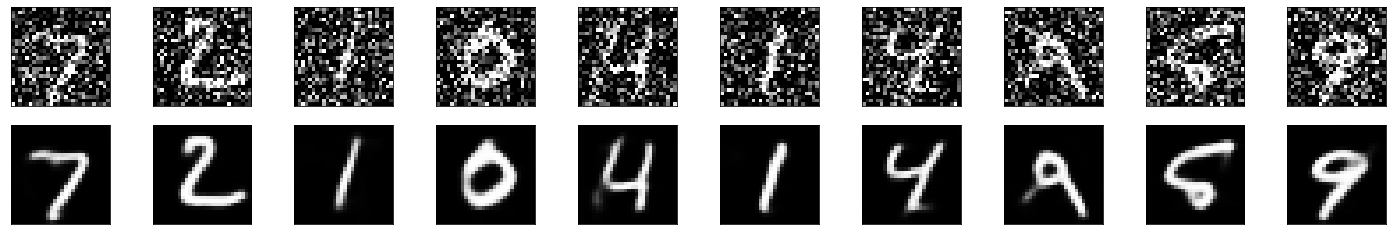

In [6]:
# obtain one batch of test images
images, labels = next(iter(test_loader))

# add noise to the test images
noise_factor = 0.5
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
noisy_imgs = noisy_imgs.to(device)
images = images.to(device)

# get sample outputs
output = conv_upscale_net(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()
fig.savefig('images/UpscaleConvDenoised.png')
plt.close()

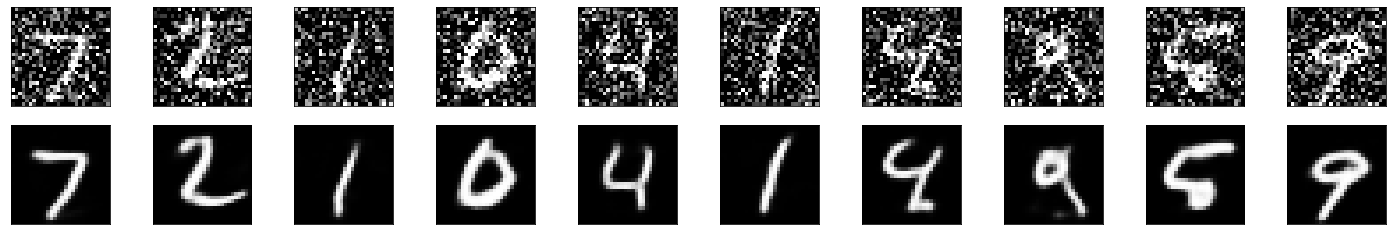

In [7]:
# obtain one batch of test images
images, labels = next(iter(test_loader))

# add noise to the test images
noise_factor = 0.5
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
noisy_imgs = noisy_imgs.to(device)
images = images.to(device)

# get sample outputs
output = conv_transpose_net(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()
fig.savefig('images/TransposeConvDenoised.png')
plt.close()